In [24]:
# Utilities

!pip install tensorflow

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
df = pd.read_csv("..\CleanDataset.csv")
df.head()

,Toxicity,tweet,tweet_clean,tweet_tokenized,tweet_tok=2,tweet_lemmatized,preprocessed_text
0,0,@user when a father is dysfunctional and is so...,father dysfunctional selfish drags kids dysfun...,"['father', 'dysfunctional', 'selfish', 'drags'...","[('father', 'dysfunctional'), ('dysfunctional'...","['father', 'dysfunctional', 'selfish', 'drag',...",father dysfunctional selfish drag kid dysfunct...
1,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit can not use cause do not ...,"['thanks', 'lyft', 'credit', 'can', 'not', 'us...","[('thanks', 'lyft'), ('lyft', 'credit'), ('cre...","['thank', 'lyft', 'credit', 'can', 'not', 'use...",thank lyft credit can not use cause do not off...
2,0,bihday your majesty,bihday majesty,"['bihday', 'majesty']","[('bihday', 'majesty')]","['bihday', 'majesty']",bihday majesty
3,0,factsguide: society now #motivation,factsguide society motivation,"['factsguide', 'society', 'motivation']","[('factsguide', 'society'), ('society', 'motiv...","['factsguide', 'society', 'motivation']",factsguide society motivation
4,0,[2/2] huge fan fare and big talking before the...,huge fan fare big talking leave chaos pay disp...,"['huge', 'fan', 'fare', 'big', 'talking', 'lea...","[('huge', 'fan'), ('fan', 'fare'), ('fare', 'b...","['huge', 'fan', 'fare', 'big', 'talk', 'leave'...",huge fan fare big talk leave chaos pay dispute...


In [26]:
X = df['preprocessed_text']
y = df["Toxicity"]

Funzioni utili

In [27]:
# Evaluation model
def model_evaluation(real_v, pred_v):
    print(f"Accuracy score: {accuracy_score(real_v, pred_v)}")
    print("Classification report:")
    print(classification_report(real_v, pred_v))
    cm = confusion_matrix(real_v, pred_v)
    print (f"Confusion matrix \n {cm}")

In [28]:
# Plot Training & validation ACCURACY then training and validation LOSS -> res = RNN fitted
def plot_Loss(res):
    train_acc = res.history['accuracy']
    val_acc = res.history['val_accuracy']
    train_loss = res.history['loss']
    val_loss = res.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, train_acc, 'g', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, train_loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [29]:
# Find longest tweet in sequences
def find_maxtweet(sequences):
    max_length = len(sequences[0])
    for i in range(1, len(sequences)):
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

# Embedding Layer

E' il primo livello  della rete neurale che incorpora i dati di input in vettori. Deve specifiare 3 argomenti:

- input_dim -> dimensione vocabolario dei dati di testo (conto parole uniche nei tweets)
- output_dim -> questa è la dimensione dello spazio vettoriale in cui verranno incorporate le parole. Definisce la dimensione dei vettori di output per ogni parola. (Sono stati provati diversi valori e si è deciso di settarlo a 10D)
- input_length ->  questa è la lunghezza delle sequenze di input(viene preso la lunghezza del tweet più lungo)

# LSTM Layer

E' il secondo livello della NN; definisce la ricorrenza della Rete Neurale ed ha memoria sia a breve che a lungo termine. Può processare singoli dati o sequenze.
Gli argomenti principali sono:

- units: interi positivi, dimensionalità dello spazio di output
- dropout: Float between 0 and 1. Frazione delle units da droppare per la trasformazione dell'input. default=0
- recurrent_dropout: Float between 0 and 1. Frazione delle units da droppare per la trasformazione dell'input dello stato ricorrente. default=0
- activation: funzione di attivazione, di default è la tangente iperbolica


# Dense Layer

E' l'ultimo livello della rete neurale, ogni neurone riceve input da tutti i neuroni del layer precedente, per questo definito "denso".

Implementa l'operazione: output = activation(dot(input, kernel) + bias) dove activation=funzione di attivazione, kernel=matrice dei pesi del layer, bias=vettore bias creato dal layer(applicabile solo se us_bias è True)

Gli argomenti principali sono:
- units:viene utilizzata una singola unità
- activation

In [30]:
# Convert training data into tensors to feed into neural net
t = Tokenizer()
t.fit_on_texts(X) # index dictionary so every word gets a unique integer value. 

# Find number of unique words in our tweets
vocabulary_size= len(t.word_index) +1

# transform each tweet in a sequence of integers
sequences = t.texts_to_sequences(X)

#find longest tweet
max_tweet=find_maxtweet(sequences)

#Le sequenze hanno lunghezze diverse e Keras preferisce che gli input siano vettorizzati e che tutti gli input abbiano la stessa lunghezza
# quindi aggiungiamo 0 alla fine di ogni sequenza affinchè siano tutte di lunghezza=max_tweet
padded_X= pad_sequences(sequences, padding='post', maxlen=max_tweet)


# Esperimento senza pre-trained embedded layer

In [31]:
#holdout
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size = 0.3)

#First layer -> embedded without pre-trained weight matrix
embedding_layer = Embedding(input_dim=vocabulary_size,output_dim=10,input_length = max_tweet)

#Second layer -> LSTM
LSTM_layer=LSTM(20, dropout=0.2, recurrent_dropout=0.2)

#Last layer -> Dense
dense_layer=Dense(1, activation='sigmoid')


#Build RNN
print('Build model...')
model = Sequential()
model.add(embedding_layer)
model.add(LSTM_layer)
model.add(dense_layer)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 31, 10)            402730    
                                                                 
 lstm_2 (LSTM)               (None, 20)                2480      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 405,231
Trainable params: 405,231
Non-trainable params: 0
_________________________________________________________________


In [32]:
batch_size=1024 # training examples used for each epoch 
epochs=30 
print('Train...')
res=model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          validation_split=0.1)

Train...
Epoch 1/30
33/33 [==============================] - 3s 39ms/step - loss: 0.6875 - accuracy: 0.5587 - val_loss: 0.6867 - val_accuracy: 0.5535
Epoch 2/30
33/33 [==============================] - 1s 31ms/step - loss: 0.6614 - accuracy: 0.5797 - val_loss: 0.4926 - val_accuracy: 0.8262
Epoch 3/30
33/33 [==============================] - 1s 30ms/step - loss: 0.3719 - accuracy: 0.8785 - val_loss: 0.3146 - val_accuracy: 0.8875
Epoch 4/30
33/33 [==============================] - 1s 29ms/step - loss: 0.2305 - accuracy: 0.9282 - val_loss: 0.2419 - val_accuracy: 0.9151
Epoch 5/30
33/33 [==============================] - 1s 30ms/step - loss: 0.1572 - accuracy: 0.9532 - val_loss: 0.2109 - val_accuracy: 0.9266
Epoch 6/30
33/33 [==============================] - 1s 29ms/step - loss: 0.1186 - accuracy: 0.9665 - val_loss: 0.2203 - val_accuracy: 0.9244
Epoch 7/30
33/33 [==============================] - 1s 29ms/step - loss: 0.0935 - accuracy: 0.9741 - val_loss: 0.2269 - val_accuracy: 0.9277
Epoc

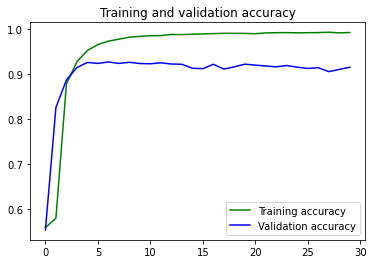

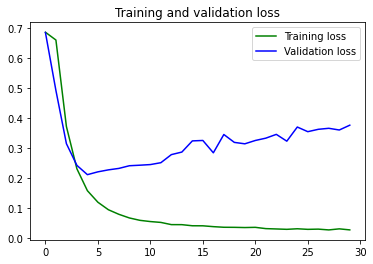

In [33]:
plot_Loss(res)

In [34]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9881
Testing Accuracy:  0.9190


In [35]:
predictions=model.predict(X_test).round().flatten() # converts predictions in integers then in 1D
predictions

490/490 [==============================] - 1s 1ms/step


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [36]:
predicted_labels = [int(a) for a in predictions]
predicted_labels

[0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


In [37]:
model_evaluation(y_test,predicted_labels)

Accuracy score: 0.9189931642496646
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      8726
           1       0.91      0.90      0.91      6927

    accuracy                           0.92     15653
   macro avg       0.92      0.92      0.92     15653
weighted avg       0.92      0.92      0.92     15653

Confusion matrix 
 [[8137  589]
 [ 679 6248]]


# Esperimento con pre-trained embedded layer 

Viene utilizzato un file di parole GloVe(Global vectors for word representation) come un dizionario di array di parole da incorporare. GloVe è un algoritmo di apprendimento non supervisionato per ottenere rappresentazioni vettoriali di testi. Le parole sono rappresentate da vettori pre-allenati. L'addestramento è stato eseguito su statistiche globali aggregate di co-occorrenza parola-parola da diversi tweet.(Il file contiene infatti circa 1M di word vectors). Nel seguito vengono estratti i vettori delle parole che compaiono nei tweet del dataset e viene utilizzata tale rappresentazione vettoriale coma matrice dei pesi per il primo livello di Embedding della rete neurale.

In [38]:

#dizionario pre-addestrato
embeddings_index = dict()
f = open("C:/Users/david/Desktop/glove.twitter.27B.25d.txt", encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


Viene creata una matrice di embedding andando ad aggiungere il vettore del peso di incorporamento di Glove, solo per le parole dei tweets presenti in X="preprocessed_text"

In [39]:
embedding_matrix = np.zeros((vocabulary_size, 25))

# fill in matrix
for word, i in t.word_index.items():  # dictionary tweets
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector # each row of matrix

Adesso nel livello di embedding abbiamo la matrice dei pesi delle parole che erano anche nel file Glove. Risulta necessario impostare output_dim=25 perchè è la dimensione con cui è stata definita la matrice dei pesi Glove.

In [40]:
#First layer -> embedded with pre-trained weight matrix
embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=25, weights=[embedding_matrix], input_length = max_tweet, trainable=False)

#Second layer -> LSTM
LSTM_layer=LSTM(20,dropout = 0.2, recurrent_dropout = 0.2)

#Last layer -> Dense
dense_layer=Dense(1, activation='sigmoid')

In [41]:
model2=Sequential()
model2.add(embedding_layer)
model2.add(LSTM_layer)
model2.add(dense_layer)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 31, 25)            1006825   
                                                                 
 lstm_3 (LSTM)               (None, 20)                3680      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,010,526
Trainable params: 3,701
Non-trainable params: 1,006,825
_________________________________________________________________


In [42]:
res2 = model2.fit(X_train, y_train,
                    validation_split = 0.1,
                    epochs=30, batch_size=1024)

Epoch 1/30
33/33 [==============================] - 4s 62ms/step - loss: 0.6756 - accuracy: 0.5948 - val_loss: 0.6055 - val_accuracy: 0.7832
Epoch 2/30
33/33 [==============================] - 2s 55ms/step - loss: 0.4473 - accuracy: 0.8439 - val_loss: 0.3555 - val_accuracy: 0.8733
Epoch 3/30
33/33 [==============================] - 2s 55ms/step - loss: 0.3456 - accuracy: 0.8706 - val_loss: 0.3164 - val_accuracy: 0.8817
Epoch 4/30
33/33 [==============================] - 2s 56ms/step - loss: 0.3129 - accuracy: 0.8779 - val_loss: 0.2922 - val_accuracy: 0.8864
Epoch 5/30
33/33 [==============================] - 2s 56ms/step - loss: 0.2971 - accuracy: 0.8824 - val_loss: 0.2801 - val_accuracy: 0.8880
Epoch 6/30
33/33 [==============================] - 2s 56ms/step - loss: 0.2861 - accuracy: 0.8875 - val_loss: 0.2788 - val_accuracy: 0.8872
Epoch 7/30
33/33 [==============================] - 2s 57ms/step - loss: 0.2795 - accuracy: 0.8911 - val_loss: 0.2644 - val_accuracy: 0.8910
Epoch 8/30
33

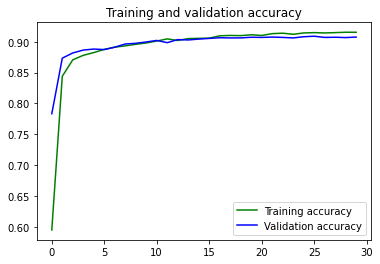

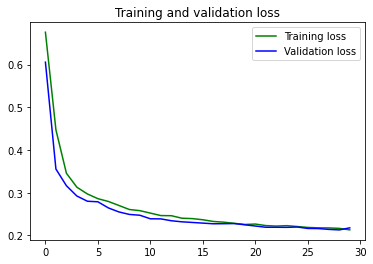

In [43]:
plot_Loss(res2)

In [44]:
# Find train and test accuracy
loss, accuracy = model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9217
Testing Accuracy:  0.9163


In [ ]:
predictions2=model2.predict(X_test).round().flatten()

In [ ]:
predicted_labels2 = [int(a) for a in predictions2]

In [45]:
model_evaluation(y_test, predicted_labels2)

490/490 [==============================] - 1s 1ms/step
Accuracy score: 0.9163099725292276
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      8726
           1       0.92      0.89      0.90      6927

    accuracy                           0.92     15653
   macro avg       0.92      0.91      0.91     15653
weighted avg       0.92      0.92      0.92     15653

Confusion matrix 
 [[8186  540]
 [ 770 6157]]
